In [1]:
# -*- coding: utf-8 -*-

# 代码5-1

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression as LR
# 参数初始化
filename = '../data/bankloan.xls'
data = pd.read_excel(filename)
x = data.iloc[:,:8].to_numpy()
y = data.iloc[:,8].to_numpy()

lr = LR()  # 建立逻辑回归模型
lr.fit(x, y)  # 用筛选后的特征数据来训练模型
print('模型的平均准确度为：%s' % lr.score(x, y))

模型的平均准确度为：0.8085714285714286


F:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [2]:
# -*- coding: utf-8 -*-
# apriori
import numpy as np
import pandas as pd


def connect_string(x, ms):
    x = list(map(lambda i: sorted(i.split(ms)), x))
    l = len(x[0])
    r = []
    for i in range(len(x)):
        for j in range(i, len(x)):
            if x[i][:l - 1] == x[j][:l - 1] and x[i][l - 1] != x[j][l - 1]:
                r.append(x[i][:l - 1] + sorted([x[j][l - 1], x[i][l - 1]]))
    return r


#寻找关联规则的函数
def find_rule(d, support, confidence, ms='--'):
    result = pd.DataFrame(index=['support', 'confidence'])  #定义输出结果

    support_series = 1.0 * d.sum() / len(d)  #支持度序列
    column = list(support_series[support_series > support].index)  #初步根据支持度筛选
    k = 0

    while len(column) > 1:
        k = k + 1
        print('\n正在进行第%s次搜索...' % k)
        column = connect_string(column, ms)
        print('数目：%s...' % len(column))
        sf = lambda i: d[i].prod(axis=1, numeric_only=True)  #新一批支持度的计算函数

        #创建连接数据，这一步耗时、耗内存最严重。当数据集较大时，可以考虑并行运算优化。
        d_2 = pd.DataFrame(list(map(sf, column)), index=[ms.join(i) for i in column]).T

        support_series_2 = 1.0 * d_2[[ms.join(i) for i in column]].sum() / len(d)  #计算连接后的支持度
        column = list(support_series_2[support_series_2 > support].index)  #新一轮支持度筛选
        support_series = support_series.append(support_series_2)
        column2 = []

        for i in column:  #遍历可能的推理，如{A,B,C}究竟是A+B-->C还是B+C-->A还是C+A-->B？
            i = i.split(ms)
            for j in range(len(i)):
                column2.append(i[:j] + i[j + 1:] + i[j:j + 1])

        cofidence_series = pd.Series(index=[ms.join(i) for i in column2])  #定义置信度序列

        for i in column2:  #计算置信度序列
            cofidence_series[ms.join(i)] = support_series[ms.join(sorted(i))] / support_series[ms.join(i[:len(i) - 1])]

        for i in cofidence_series[cofidence_series > confidence].index:  #置信度筛选
            result[i] = 0.0
            result[i]['confidence'] = cofidence_series[i]
            result[i]['support'] = support_series[ms.join(sorted(i.split(ms)))]

    result = result.T.sort_values(['confidence', 'support'], ascending=False)  #结果整理，输出
    print('\n结果为：')
    print(result)
    return result

In [3]:
# -*- coding: utf-8 -*-
#cal_apriori

from __future__ import print_function
import pandas as pd
from apriori import *  # 导入自行编写的apriori函数

inputfile = '../data/menu_orders.xls'
outputfile = '../tmp/apriori_rules.xls'  # 结果文件
data = pd.read_excel(inputfile, header=None)

print('\n转换原始数据至0-1矩阵...')
ct = lambda x: pd.Series(1, index=x[pd.notnull(x)])  # 转换0-1矩阵的过渡函数
b = map(ct, data.to_numpy())  # 用map方式执行
data = pd.DataFrame(list(b)).fillna(0)  # 实现矩阵转换，空值用0填充
print('\n转换完毕。')
del b  # 删除中间变量b，节省内存

support = 0.2  # 最小支持度
confidence = 0.5  # 最小置信度
ms = '---'  # 连接符，默认'--'，用来区分不同元素，如A--B。需要保证原始表格中不含有该字符

find_rule(data, support, confidence, ms).to_excel(outputfile)  # 保存结果


转换原始数据至0-1矩阵...

转换完毕。

正在进行第1次搜索...
数目：6...

正在进行第2次搜索...
数目：3...

正在进行第3次搜索...
数目：0...

结果为：
           support  confidence
e---a          0.3    1.000000
e---c          0.3    1.000000
c---e---a      0.3    1.000000
a---e---c      0.3    1.000000
c---a          0.5    0.714286
a---c          0.5    0.714286
a---b          0.5    0.714286
c---b          0.5    0.714286
b---a          0.5    0.625000
b---c          0.5    0.625000
a---c---e      0.3    0.600000
b---c---a      0.3    0.600000
a---c---b      0.3    0.600000
a---b---c      0.3    0.600000


F:\算法数据挖掘\上机实习 2022\上机实习 2022\chapter5\demo\code\apriori.py:35: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  support_series = support_series.append(support_series_2)
F:\算法数据挖掘\上机实习 2022\上机实习 2022\chapter5\demo\code\apriori.py:43: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cofidence_series = pd.Series(index=[ms.join(i) for i in column2]) #定义置信度序列
F:\算法数据挖掘\上机实习 2022\上机实习 2022\chapter5\demo\code\apriori.py:35: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  support_series = support_series.append(support_series_2)
F:\算法数据挖掘\上机实习 2022\上机实习 2022\chapter5\demo\code\apriori.py:43: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a d

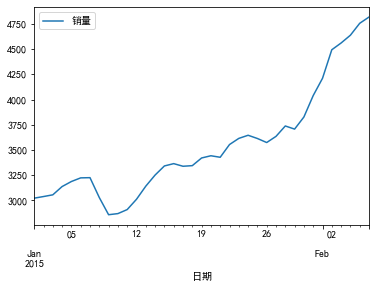

In [4]:
# -*- coding: utf-8 -*-
#arima_test

import pandas as pd

# 参数初始化
discfile = '../data/arima_data.xls'
forecastnum = 5

# 读取数据，指定日期列为指标，pandas自动将“日期”列识别为Datetime格式
data = pd.read_excel(discfile, index_col='日期')
# 时序图
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
data.plot()
plt.show()


C:\Users\23571\AppData\Local\Temp\ipykernel_12792\1895267164.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(data).show()


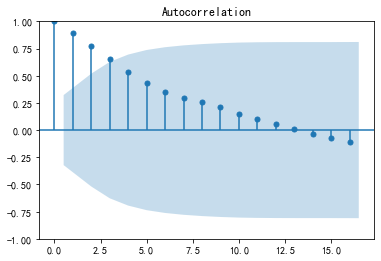

In [5]:
# 自相关图
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data).show()

原始序列的ADF检验结果为： (1.8137710150945274, 0.9983759421514264, 10, 26, {'1%': -3.7112123008648155, '5%': -2.981246804733728, '10%': -2.6300945562130176}, 299.46989866024177)


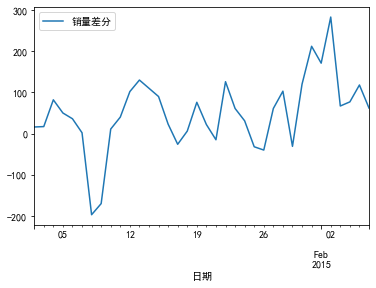

C:\Users\23571\AppData\Local\Temp\ipykernel_12792\1932638119.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_acf(D_data).show()  # 自相关图


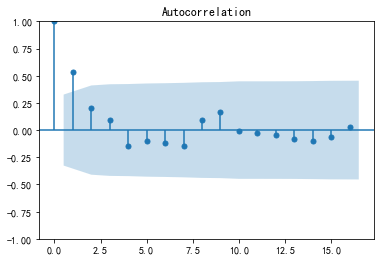

In [6]:
# 平稳性检测
from statsmodels.tsa.stattools import adfuller as ADF

print('原始序列的ADF检验结果为：', ADF(data['销量']))
# 返回值依次为adf、pvalue、usedlag、nobs、critical values、icbest、regresults、resstore

# 差分后的结果
D_data = data.diff().dropna()
D_data.columns = ['销量差分']
D_data.plot()  # 时序图
plt.show()
plot_acf(D_data).show()  # 自相关图


F:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


差分序列的ADF检验结果为： (-3.1560562366723537, 0.022673435440048798, 0, 35, {'1%': -3.6327426647230316, '5%': -2.9485102040816327, '10%': -2.6130173469387756}, 287.5909090780334)


C:\Users\23571\AppData\Local\Temp\ipykernel_12792\169705133.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot_pacf(D_data).show()  # 偏自相关图


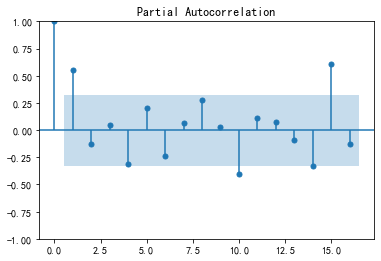

In [7]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(D_data).show()  # 偏自相关图
print('差分序列的ADF检验结果为：', ADF(D_data['销量差分']))  # 平稳性检测

In [8]:
# 白噪声检验
from statsmodels.stats.diagnostic import acorr_ljungbox

print('差分序列的白噪声检验结果为：', acorr_ljungbox(D_data, lags=1))  # 返回统计量和p值


差分序列的白噪声检验结果为：      lb_stat  lb_pvalue
1  11.304022   0.000773


In [9]:
from statsmodels.tsa.arima_model import ARIMA

# 定阶
data['销量'] = data['销量'].astype(float)
pmax = int(len(D_data) / 10)  # 一般阶数不超过length/10
qmax = int(len(D_data) / 10)  # 一般阶数不超过length/10
bic_matrix = []  # BIC矩阵
for p in range(pmax + 1):
    tmp = []
    for q in range(qmax + 1):
        try:  # 存在部分报错，所以用try来跳过报错。
            tmp.append(ARIMA(data, (p, 1, q)).fit().bic)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)

bic_matrix = pd.DataFrame(bic_matrix)  # 从中可以找出最小值

p, q = bic_matrix.stack().astype('float').idxmin()  # 先用stack展平，然后用idxmin找出最小值位置。
print('BIC最小的p值和q值为：%s、%s' % (p, q))
model = ARIMA(data, (p, 1, q)).fit()  # 建立ARIMA(0, 1, 1)模型
print('模型报告为：\n', model.summary2())
print('预测未来5天，其预测结果、标准误差、置信区间如下：\n', model.forecast(5))

ValueError: attempt to get argmin of an empty sequence

In [10]:
#-*- coding: utf-8 -*-
def cm_plot(y, yp):
    from sklearn.metrics import confusion_matrix  #�������������

    cm = confusion_matrix(y, yp)  #��������

    import matplotlib.pyplot as plt  #������ͼ��
    plt.matshow(cm, cmap=plt.cm.Greens)  #����������ͼ����ɫ���ʹ��cm.Greens����������ο�������
    plt.colorbar()  #��ɫ��ǩ

    for x in range(len(cm)):  #���ݱ�ǩ
        for y in range(len(cm)):
            plt.annotate(cm[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center')

    plt.ylabel('True label')  #�������ǩ
    plt.xlabel('Predicted label')  #�������ǩ
    return plt

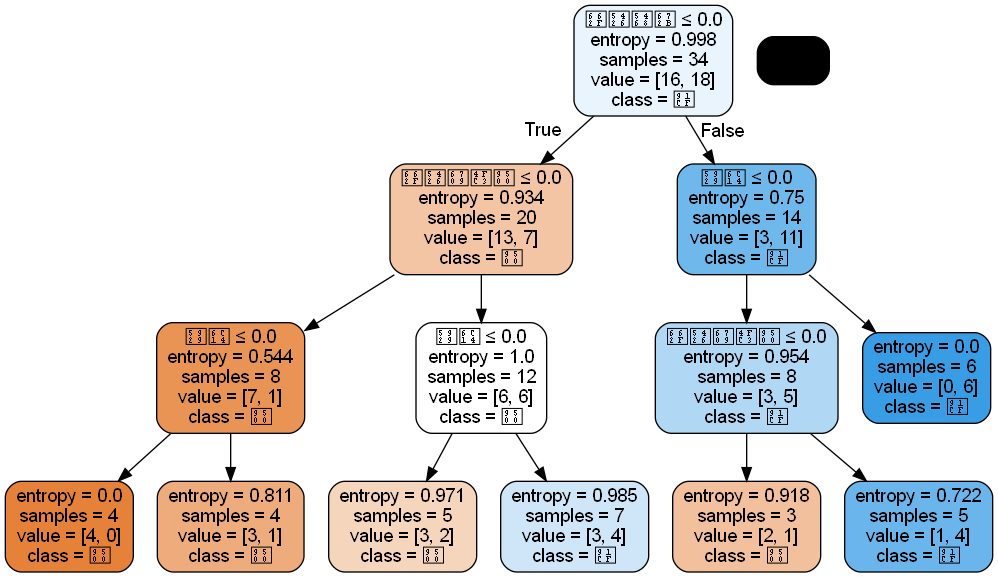

In [11]:
# -*- coding: utf-8 -*-

# 代码5-2

import pandas as pd

# 参数初始化
filename = '../data/sales_data.xls'
data = pd.read_excel(filename, index_col='序号')  # 导入数据

# 数据是类别标签，要将它转换为数据
# 用1来表示“好”“是”“高”这三个属性，用-1来表示“坏”“否”“低”
data[data == '好'] = 1
data[data == '是'] = 1
data[data == '高'] = 1
data[data != 1] = -1
x = data.iloc[:, :3].astype(int)
y = data.iloc[:, 3].astype(int)

from sklearn.tree import DecisionTreeClassifier as DTC

dtc = DTC(criterion='entropy')  # 建立决策树模型，基于信息熵
dtc.fit(x, y)  # 训练模型

# 导入相关函数，可视化决策树。
# 导出的结果是一个dot文件，需要安装Graphviz才能将它转换为pdf或png等格式。
from sklearn.tree import export_graphviz

x = pd.DataFrame(x)

"""
string1 = '''
edge [fontname="NSimSun"];
node [ fontname="NSimSun" size="15,15"];
{
'''
string2 = '}'
"""

with open("../tmp/tree.dot", 'w') as f:
    export_graphviz(dtc, feature_names=x.columns, out_file=f)
    f.close()


from IPython.display import Image
from sklearn import tree
import pydotplus

dot_data = tree.export_graphviz(dtc, out_file=None,  #regr_1 是对应分类器
                         feature_names=data.columns[:3],   #对应特征的名字
                         class_names=data.columns[3],    #对应类别的名字
                         filled=True, rounded=True,
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('../tmp/example.png')    #保存图像
Image(graph.create_png())


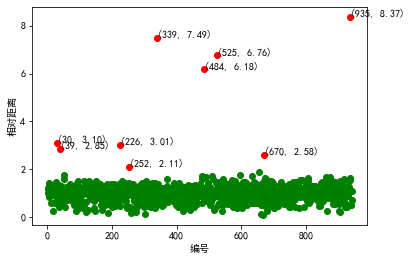

In [12]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd

# 参数初始化
inputfile = '../data/consumption_data.xls'  # 销量及其他属性数据
k = 3  # 聚类的类别
threshold = 2  # 离散点阈值
iteration = 500  # 聚类最大循环次数
data = pd.read_excel(inputfile, index_col='Id')  # 读取数据
data_zs = 1.0 * (data - data.mean()) / data.std()  # 数据标准化

from sklearn.cluster import KMeans

model = KMeans(n_clusters=k, max_iter=iteration)  # 分为k类，并发数4
model.fit(data_zs)  # 开始聚类

# 标准化数据及其类别
r = pd.concat([data_zs, pd.Series(model.labels_, index=data.index)], axis=1)  # 每个样本对应的类别
r.columns = list(data.columns) + ['聚类类别']  # 重命名表头

norm = []
for i in range(k):  # 逐一处理
    norm_tmp = r[['R', 'F', 'M']][r['聚类类别'] == i] - model.cluster_centers_[i]
    norm_tmp = norm_tmp.apply(np.linalg.norm, axis=1)  # 求出绝对距离
    norm.append(norm_tmp / norm_tmp.median())  # 求相对距离并添加

norm = pd.concat(norm)  # 合并

import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
norm[norm <= threshold].plot(style='go')  # 正常点

discrete_points = norm[norm > threshold]  # 离群点
discrete_points.plot(style='ro')

for i in range(len(discrete_points)):  # 离群点做标记
    id = discrete_points.index[i]
    n = discrete_points.iloc[i]
    plt.annotate('(%s, %0.2f)' % (id, n), xy=(id, n), xytext=(id, n))

plt.xlabel('编号')
plt.ylabel('相对距离')
plt.show()

          R         F         M  类别数目
0 -0.160451  1.114802  0.392844   341
1  3.455055 -0.295654  0.449123    40
2 -0.149353 -0.658893 -0.271780   559


C:\Users\23571\AppData\Local\Temp\ipykernel_12792\1799118289.py:28: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead. You can set the option io.excel.xls.writer to 'xlwt' to silence this warning. While this option is deprecated and will also raise a warning, it can be globally set and the warning suppressed.
  r.to_excel(outputfile)  # 保存结果


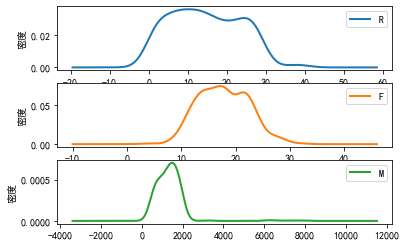

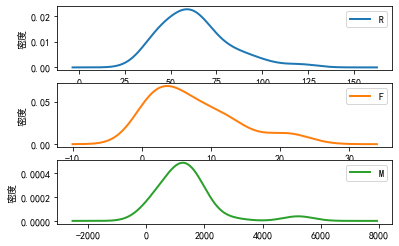

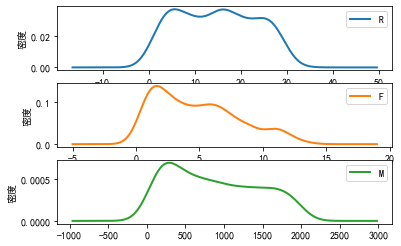

In [13]:
# -*- coding: utf-8 -*-

import pandas as pd

# 参数初始化
inputfile = '../data/consumption_data.xls'  # 销量及其他属性数据
outputfile = '../tmp/data_type.xls'  # 保存结果的文件名
k = 3  # 聚类的类别
iteration = 500  # 聚类最大循环次数
data = pd.read_excel(inputfile, index_col='Id')  # 读取数据
data_zs = 1.0 * (data - data.mean()) / data.std()  # 数据标准化

from sklearn.cluster import KMeans

model = KMeans(n_clusters=k, max_iter=iteration, random_state=1234)  # 分为k类，并发数4
model.fit(data_zs)  # 开始聚类

# 简单打印结果
r1 = pd.Series(model.labels_).value_counts()  # 统计各个类别的数目
r2 = pd.DataFrame(model.cluster_centers_)  # 找出聚类中心
r = pd.concat([r2, r1], axis=1)  # 横向连接（0是纵向），得到聚类中心对应的类别下的数目
r.columns = list(data.columns) + ['类别数目']  # 重命名表头
print(r)

# 详细输出原始数据及其类别
r = pd.concat([data, pd.Series(model.labels_, index=data.index)], axis=1)  # 详细输出每个样本对应的类别
r.columns = list(data.columns) + ['聚类类别']  # 重命名表头
r.to_excel(outputfile)  # 保存结果


def density_plot(data):  # 自定义作图函数
    import matplotlib.pyplot as plt
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
    p = data.plot(kind='kde', linewidth=2, subplots=True, sharex=False)
    [p[i].set_ylabel('密度') for i in range(k)]
    plt.legend()
    return plt


pic_output = '../tmp/pd'  # 概率密度图文件名前缀
for i in range(k):
    density_plot(data[r['聚类类别'] == i]).savefig('%s%s.png' % (pic_output, i))

Epoch 1/1000
4/4 [==============================] - 1s 3ms/step - loss: 0.9416
Epoch 2/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.9295
Epoch 3/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.9187
Epoch 4/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.9079
Epoch 5/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.8978
Epoch 6/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.8863
Epoch 7/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.8780
Epoch 8/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.8681
Epoch 9/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.8600
Epoch 10/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.8520
Epoch 11/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.8453
Epoch 12/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.8364
Epoch 13/1000
4/4 [==============================

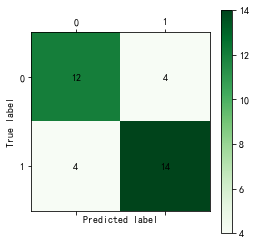

In [14]:
# -*- coding: utf-8 -*-


import pandas as pd
import numpy as np
# 参数初始化
inputfile = '../data/sales_data.xls'
data = pd.read_excel(inputfile, index_col = '序号')  # 导入数据

# 数据是类别标签，要将它转换为数据
# 用1来表示“好”“是”“高”这三个属性，用0来表示“坏”“否”“低”
data[data == '好'] = 1
data[data == '是'] = 1
data[data == '高'] = 1
data[data != 1] = 0
x = data.iloc[:,:3].astype(int)
y = data.iloc[:,3].astype(int)

from keras.models import Sequential
from keras.layers.core import Dense, Activation

model = Sequential()  # 建立模型
model.add(Dense(input_dim = 3, units = 10))
model.add(Activation('relu'))  # 用relu函数作为激活函数，能够大幅提供准确度
model.add(Dense(input_dim = 10, units = 1))
model.add(Activation('sigmoid'))  # 由于是0-1输出，用sigmoid函数作为激活函数

model.compile(loss = 'binary_crossentropy', optimizer = 'adam')
# 编译模型。由于我们做的是二元分类，所以我们指定损失函数为binary_crossentropy，以及模式为binary
# 另外常见的损失函数还有mean_squared_error、categorical_crossentropy等，请阅读帮助文件。
# 求解方法我们指定用adam，还有sgd、rmsprop等可选

model.fit(x, y, epochs = 1000, batch_size = 10)  # 训练模型，学习一千次
yp = model.predict(x).reshape(len(y))  # 分类预测
yp = (yp>0.5).astype("int32")
from cm_plot import *  # 导入自行编写的混淆矩阵可视化函数
cm_plot(y,yp).show()  # 显示混淆矩阵可视化结果

F:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
F:\Anaconda\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


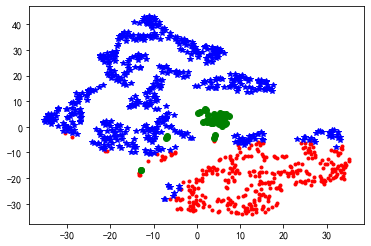

In [15]:
# -*- coding: utf-8 -*-


import pandas as pd
from sklearn.manifold import TSNE
# 参数初始化
inputfile = '../data/consumption_data.xls'  # 销量及其他属性数据
inputfile1 = '../tmp/data_type.xls'
data = pd.read_excel(inputfile, index_col = 'Id')  # 读取数据
data_zs = 1.0*(data - data.mean())/data.std()
r = pd.read_excel(inputfile1,index_col='Id')

tsne = TSNE(random_state=105)
tsne.fit_transform(data_zs)  # 进行数据降维
tsne = pd.DataFrame(tsne.embedding_, index = data_zs.index)  # 转换数据格式

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 不同类别用不同颜色和样式绘图
d = tsne[r['聚类类别'] == 0]
plt.plot(d[0], d[1], 'r.')
d = tsne[r['聚类类别'] == 1]
plt.plot(d[0], d[1], 'go')
d = tsne[r['聚类类别'] == 2]
plt.plot(d[0], d[1], 'b*')
plt.show()